In [ ]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import models
from torchvision import transforms
import time
import hiddenlayer as hl
from skimage.io import imread

In [ ]:
!pip install hiddenlayer

In [ ]:
# 使用Vgg19网络来获取特征
vgg19 = models.vgg19(pretrained=True)
## 不需要网络的分类器，只需要卷积和池化层
vgg = vgg19.features
## 输出vgg
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPo

In [ ]:
# ## 可视化卷积神经网络
# hl_graph = hl.build_graph(vgg19, torch.zeros([1, 3, 224, 224]))
# hl_graph.theme = hl.graph.THEMES["blue"].copy()  
# hl_graph
# ## 可视化卷积神经网络
# hl_graph = hl.build_graph(vgg19, torch.zeros([1, 3, 224, 224]))
# hl_graph.theme = hl.graph.THEMES["blue"].copy()  
# hl_graph

In [ ]:
# 将VGG19的特征提取网络权重冻结，在训练时不更新
for param in vgg.parameters():
    param.requires_grad_(False)

In [ ]:
## 定义一个读取风格图像或内容图像的函数，并且将图像进行表转化
def load_image(img_path, max_size=400, shape=None):
    """
    读取图像并且保证图像的高和宽都小于400
    """
    image = Image.open(img_path).convert('RGB')
    ## 如果图像尺寸过大，就对图像进行尺寸转换
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    ## 如果指定了图像的尺寸，就将图像转化为shape指定的尺寸
    if shape is not None:
        size = shape
    ## 使用transforms将图像转化为张量，并进行标准化
    in_transform = transforms.Compose(
        [transforms.Resize(size), # 图像尺寸变换,图像的短边匹配size
         transforms.ToTensor(), # 数组转化为张量
         ## 图像进行标准化
         transforms.Normalize((0.485, 0.456, 0.406), 
                              (0.229, 0.224, 0.225))])
    # 使用图像的RGB通道，并且添加batch纬度
    image = in_transform(image)[:3,:,:].unsqueeze(dim=0)   
    return image

In [ ]:
# 定义一个将标准化后的图像转化为便于利用matplotlib可视化的函数
def im_convert(tensor):
    """ 
    将[1, c, h, w]纬度的张量转化为[ h, w,c]的数组
    因为张量进行了表转化，所以要进行标准化逆变换
    """
    image = tensor.data.numpy().squeeze() # 去处batch纬度数据
    image = image.transpose(1,2,0) ## 置换数组的纬度[c,h,w]->[h,w,c]
    ## 进行标准化的逆操作
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1) ##  将图像的取值剪切到0～1之间
    return image

content shape: torch.Size([1, 3, 400, 640])
style shape: torch.Size([1, 3, 400, 640])


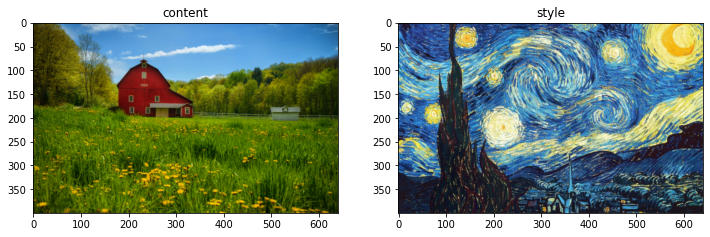

In [ ]:
# 读取内容和风格图像
content = load_image("tar58.png",max_size=400)
print("content shape:",content.shape)
# 根据内容图像的宽和高来设置风格图像的宽和高
style = load_image("tar21.png", shape=content.shape[-2:])
print("style shape:",style.shape)
## 可视化图像
# 可视化内容图像和风格图像
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax1.set_title("content")
ax2.imshow(im_convert(style))
ax2.set_title("style")
plt.show()

In [ ]:
## 定义一个函数，用于获取图像在网络上置顶层的输出
def get_features(image, model, layers=None):
    """
    将一张图像image在一个网络model中进行前向传播计算，并获取指定层layers中的特征输出
    """
    ## TODO: 将PyTorch的VGGNet的完整映射层名称与论文中的名称相对应
    ## layers参数指定：需要用于图像的内容和样式表示的图层
    ## 如果layers没有指定，就是哟过默认的层
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv5_2',  ## 内容图层的表示
                  '28': 'conv5_1'}
        
    features = {} ## 获取的每层特征保存到字典中
    x = image  ## 需要获取特征的图像
    # model._modules是一个字典，保存着网络model每层的信息
    for name, layer in model._modules.items():
        ## 从第一层开始获取图像的特征
        x = layer(x)
        ## 如果是layers参数指定的特征，那就保存到feature中
        if name in layers:
            features[layers[name]] = x
    return features

In [ ]:
## 定义计算格拉姆矩阵
def gram_matrix(tensor):
    """ 
    计算指定向量的Gram Matrix，该矩阵表示了图像的风格特征，
    格拉姆矩阵最终能够在保证内容的情况下，进行风格的传输。
    tensor:是一张图像前向计算后的一层特征映射
    """
    # 获得tensor的batch_size, depth, height,  width
    _, d, h, w = tensor.size()
    # 该变矩阵的纬度为（深度，高＊宽）
    tensor = tensor.view(d, h * w)
    # 计算gram matrix
    gram = torch.mm(tensor, tensor.t())
    return gram

In [ ]:
# 计算在第一次训练之前内容特征和风格特征，使用get_features函数
content_features = get_features(content, vgg)
## 计算风格图像的风格表示
style_features = get_features(style, vgg)

# 为我们的风格表示计算每层的格拉姆矩阵，使用字典保存
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

## 使用内容图像的副本创建一个“目标”图像，训练时对目标图像进行调整
target = content.clone().requires_grad_(True)

# 定义每个样式层的权重
# 需要注意的是`conv4_2` 是内容图像的表示
style_weights = {'conv1_1': 0.25,
         'conv2_1': 0.25,
         'conv3_1': 1,
         'conv4_1': 1,
         'conv5_1': 1}

alpha = 0.025
beta = 1
content_weight = alpha
style_weight = beta

In [ ]:
# 训练并且对结果进行输出
show_every = 100  ## 每迭代10次输出一个中间结果
## 将损失保存
total_loss_all = []
content_loss_all = []
style_loss_all = []
# 使用adam优化器
optimizer = optim.Adam([target], lr=0.01)
steps = 1000  # 优化时迭代的次数
t0 = time.time() # 计算需要的时间
for ii in range(1, steps+1):
    # 获取目标图像的特征
    target_features = get_features(target, vgg)
    # 计算内容损失
    content_loss = torch.mean((target_features['conv5_2'] - content_features['conv5_2'])**2)
    # 计算风格损失，并且初始化为0
    style_loss = 0
    # 将每个层的gram matrix损失相加
    for layer in style_weights:
        ## 计算要生成的图像的风格表示
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        ## 获取风格图像在每层的风格的gram matrix
        style_gram = style_grams[layer]
        # 计算要生成图像的风格和参考风格图像的风格之间的差异，每层都有一个权重
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # 累加计算风格差异损失
        style_loss += layer_style_loss / (d * h * w)
        
    # 计算一次迭代的总的损失，内容损失和风格损失的加权和
    total_loss = content_weight * content_loss + style_weight * style_loss
    ##  保留三种损失大小
    content_loss_all.append(content_loss.item())
    style_loss_all.append(style_loss.item())
    total_loss_all.append(total_loss.item())
    
    ## 更新需要生成的目标图像
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # 输出没show_every次迭代后的生成图像
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Use time: ', (time.time() - t0)/60 , " minutes")
        newim = im_convert(target)
        plt.imshow(newim)
        plt.title("Iteration: " + str(ii) + " times")
        plt.show()
        ## 保存图片
        result = Image.fromarray((newim * 255).astype(np.uint8))
        result.save(str(ii)+".bmp")

Output hidden; open in https://colab.research.google.com to view.